# Churn Prediction

## Task Description

#### Pattern
There are 3 aggregated reasons of Churn (resignation of service by client) defined by Payability customer service:
1.	No longer active on Amazon (27% last 12 mths) - Supplier’s sales decline, leading to end of business
1.	Outgrew Payability (27% last 12 mths) - Supplier’s sales significantly incline and Supplier is getting other financing
1.	Product complaint (46% last 12 mths)

#### Task
Analyse first 2 points of above Churn reasons.

Having sales history data, prepare a model classifying the trend of sales as inclining or declining [or any other you see useful] and test the accuracy of model on given dataset. Check whether is there correlation of trend movement to churn event (churn happened if there is a date given in churn dataset – if there is no date, the client is still using our service) – verify the hipothesis stated by Customer Service.

Provide GitHub (or any similar, BitBucket etc.) link to Python script that you created during the analysis.


## Imports

In [1]:
import pdb
import pathlib
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

style.use('seaborn')
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

from fbprophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [2]:
PATH = pathlib.Path('')

In [3]:
list(PATH.iterdir())

[WindowsPath('.ipynb_checkpoints'),
 WindowsPath('Churn Prediction.odt'),
 WindowsPath('churn_data.csv'),
 WindowsPath('Churn_Prediction-Tomasz_Kaleczyc.ipynb'),
 WindowsPath('seller_performance_data.csv')]

## Getting the Dataset

First let's import the sales data from one of the .csv files:

In [4]:
sales = pd.read_csv('seller_performance_data.csv', sep=";", index_col=0, decimal=','); sales.head()

,supplier_key,report_date,ordered_product_sales,ordered_product_sales_b2b,units_ordered,units_ordered_b2b,units_refunded
1,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-24,"1,651.50",0.00,214,0,0
2,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-23,"1,728.16",0.00,193,0,0
3,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-22,"2,115.83",0.00,188,0,0
4,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-21,"1,304.69",0.00,160,0,0
5,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-20,536.08,0.00,86,0,0


Let's look at some of the statistics behind the provided features:

In [5]:
sales.describe(include="all")

,supplier_key,report_date,ordered_product_sales,ordered_product_sales_b2b,units_ordered,units_ordered_b2b,units_refunded
count,278975,278975,"278,975.00","278,975.00","278,975.00","278,975.00","278,975.00"
unique,284,1443,nan,nan,nan,nan,nan
top,42025894-fe3b-47e1-88d7-52ac45c5348f,2016-12-17,nan,nan,nan,nan,nan
freq,1442,284,nan,nan,nan,nan,nan
mean,NaN,NaN,931.69,27.65,37.08,1.04,0.76
std,NaN,NaN,"4,914.09",330.80,271.21,14.74,7.89
min,NaN,NaN,0.00,0.00,0.00,0.00,-1.00
25%,NaN,NaN,0.00,0.00,0.00,0.00,0.00
50%,NaN,NaN,32.98,0.00,1.00,0.00,0.00
75%,NaN,NaN,397.77,0.00,14.00,0.00,0.00


It looks like the dataset is a summary of a Suppliers' sales for a given date - the number of unique Suppliers keys matches the most common frequency of report dates and the other way around. 

Just to confirm, let's check if the unique combinations of keys and dates matches the number of dataset rows:

In [6]:
len((sales['report_date'].map(str) + sales['supplier_key'].map(str)).unique()) == len(sales)

True

Now let's import the other provided .csv file:

In [7]:
churn = pd.read_csv('churn_data.csv', sep=";", index_col=0); churn.head()

,supplier_key,churn_date
1,031a13f1-5488-4ef8-a2fa-e55bb894c44e,2018-01-18
2,03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5,2016-12-09
3,0574ad4e-5331-4e0b-9dd5-70d8fd3ba01b,2018-01-19
4,073941ba-16e0-4a1f-825e-1cd94b9d50cb,2017-04-27
5,082ba7d5-7b68-46e3-8a53-fc4d52104e28,2018-10-02


In [8]:
churn.describe(include="all")

,supplier_key,churn_date
count,141,141
unique,141,131
top,94b630cd-e51e-4cf8-a620-6891fba61ff9,2018-02-15
freq,1,4


This dataset is simply a mapping table of Supplier churn dates per Supplier. We can map it back to the sales data by performing a left join on the sales `supplier_key`:

In [9]:
df = sales.merge(churn, how="left", on="supplier_key"); df.head()

,supplier_key,report_date,ordered_product_sales,ordered_product_sales_b2b,units_ordered,units_ordered_b2b,units_refunded,churn_date
0,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-24,"1,651.50",0.00,214,0,0,NaN
1,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-23,"1,728.16",0.00,193,0,0,NaN
2,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-22,"2,115.83",0.00,188,0,0,NaN
3,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-21,"1,304.69",0.00,160,0,0,NaN
4,00179d2b-e696-4536-b530-e25ed838fae6,2018-10-20,536.08,0.00,86,0,0,NaN


As per the **Task Description** - and quite obviously - `churn_date` is only provided for Suppliers who stopped using the services, resulting in empty (`NaN`) values for any customer records that are still on board:

In [10]:
df.isna().sum()

supplier_key                      0
report_date                       0
ordered_product_sales             0
ordered_product_sales_b2b         0
units_ordered                     0
units_ordered_b2b                 0
units_refunded                    0
churn_date                   163272
dtype: int64

The date features can be set as proper timestamps:

In [11]:
for col in ['report_date', 'churn_date']: df[col] = pd.to_datetime(df[col])
df.dtypes

supplier_key                         object
report_date                  datetime64[ns]
ordered_product_sales               float64
ordered_product_sales_b2b           float64
units_ordered                         int64
units_ordered_b2b                     int64
units_refunded                        int64
churn_date                   datetime64[ns]
dtype: object

Let's use the `churn_date` to formulate a new feature indicating if the Supplier is still on board or not:

In [12]:
df['exit_supplier'] = df['churn_date'].apply(func=(lambda x: 1 if pd.notnull(x) else 0)); df['exit_supplier'].value_counts()

0    163272
1    115703
Name: exit_supplier, dtype: int64

Before we move on, let's check if all the suppliers in the `churn` table are present in the `sales` table as well:

In [13]:
churn[~churn['supplier_key'].isin(sales['supplier_key'].unique())]

,supplier_key,churn_date
9,093222f2-0030-4b9f-833e-b1395b1cf824,2016-02-03
24,2c624e3d-30a6-4328-9767-c78100ab26c7,2017-07-06
34,4408ef25-a930-42c2-9036-d2a73dba06f0,2016-12-27
36,45cdfd3b-7092-4e6f-a373-8f384a7f4304,2018-02-16
57,6d8136e4-8c5a-43f4-9d66-4c284766a81a,2016-10-18
60,6f9fbc7d-23fc-4a13-9223-971ec59ea175,2017-11-03
63,7a32a17c-3b0a-41ca-ae95-ce6b76e85dea,2016-01-25
70,815c6552-086b-420f-bd78-989254bcb34d,2016-09-12
74,898b3237-3a03-459f-b1e0-b4e285aaeedd,2016-12-12
94,a776a378-a343-4286-98a3-6675d68e2f51,2018-04-03


These 14 Suppliers have no sales records in the provided sales table. It is unclear whether this is a data quality issue or these Suppliers generated no sales in the analysed period. For now, we will exclude them from the analysis.

One last thing regarding data: we will append the dataset with 0 sales records wherever the Supplier churn date is later than the last report date. This step will allow us to better capture the churn event and understand which Suppliers have had a period of no sales prior to leaving Payability.

In [14]:
suppliers = df['supplier_key'][df['exit_supplier'] == 1].unique()
cols = ['ordered_product_sales',
       'ordered_product_sales_b2b', 'units_ordered', 'units_ordered_b2b',
       'units_refunded']
dic = {col: 0. for col in cols}
for supplier in suppliers:
    max_rep_date = df['report_date'][df['supplier_key'] == supplier].max()
    churn_date = df['churn_date'][df['supplier_key'] == supplier].max()
    if churn_date > max_rep_date:
        di = {'report_date': churn_date, 'supplier_key': supplier, 'churn_date': churn_date, 'exit_supplier': 1}
        di.update(dic)
        df = df.append([di])

## Exploratory Data Analysis

### First glance at data

Ok, now it's time to visualise the data:

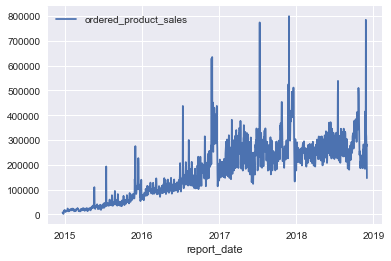

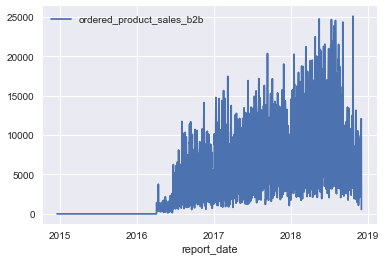

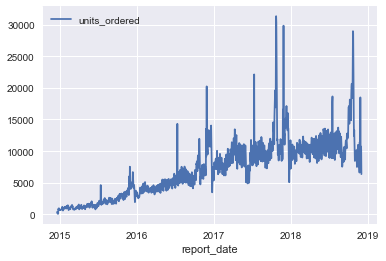

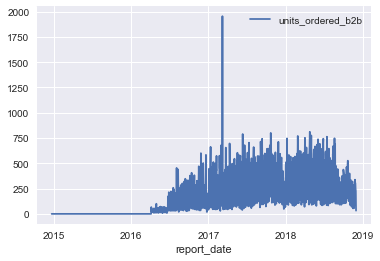

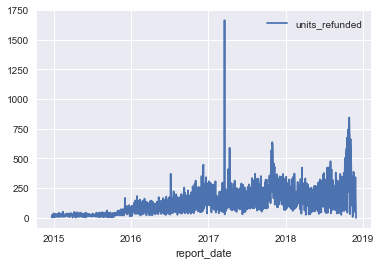

In [15]:
cols = ['ordered_product_sales',
       'ordered_product_sales_b2b', 'units_ordered', 'units_ordered_b2b',
       'units_refunded']

for col in cols: df[['report_date', col]].groupby('report_date').sum().plot()

The data looks to be very 'noisy', which is understandable given this is daily frequency.

In particular in the ordered sales data (which is of primary importance for us according to the **Task Description**) we can see a number of outliers and, quite possibly, impact of seasonality as well. 

To understand the dataset better we will analyse the `ordered_product_sales` further using the [*Facebook Prophet*](https://github.com/facebook/prophet) package. It allows constructing specialised GAM's (Generalised Additive Model) for time series analysis.

In order to alleviate the impact of outliers on the dataset, we will model the log of sales instea of the sales directly:

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


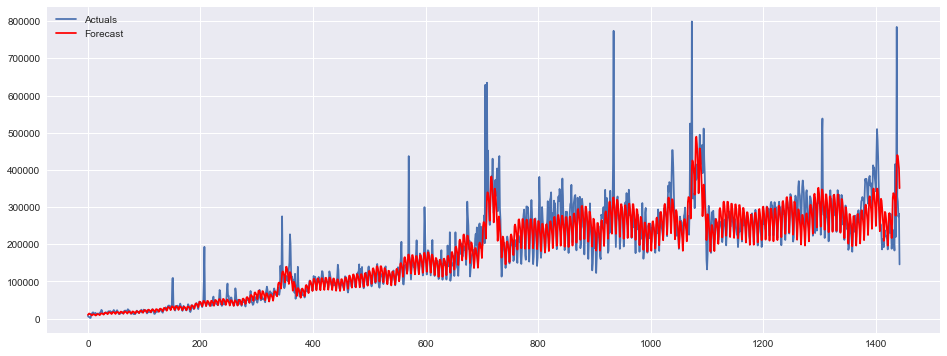

In [16]:
# Getting the data:
fb = df[['report_date', 'ordered_product_sales']].groupby('report_date').sum().reset_index()
fb.columns = ['ds', 'y']  # Naming convention required by the package
fb['y'] = np.log(fb['y'])  # log transformation

# Fitting the model:
m = Prophet()
m.fit(fb)
forecast = m.predict(fb)

# Plotting the result (back to original scale)
plt.figure(figsize=(16, 6))
np.exp(fb['y'].rename("Actuals")).plot(legend=True)
np.exp(forecast['yhat'].rename("Forecast")).plot(legend=True, color='r')
plt.show()

Now that we have a reasonable model of the sales time series, let's look at the seasonality details:

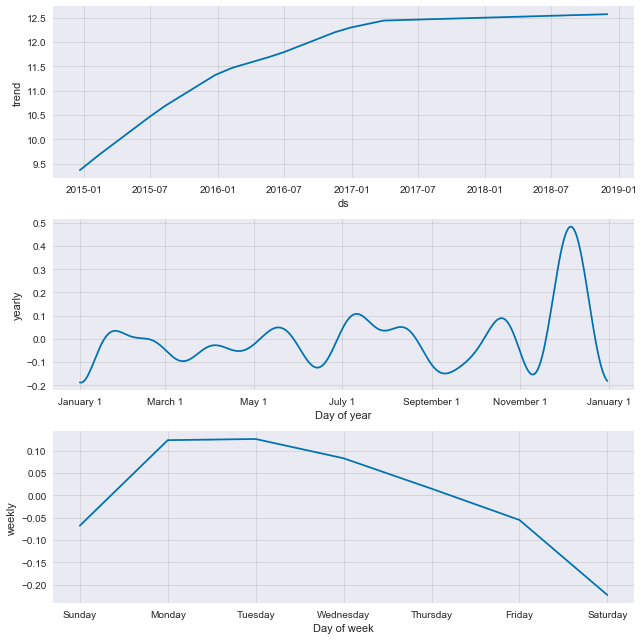

In [17]:
m.plot_components(forecast);

As suspected, there is monthly seasonality in the data with a sales spike around December - a phenomenon commonly observed in the retail industry linked to Christmas. This is surely something to keep in mind for any modelling stages.

There's also an apparent weekly seasonality, with sales being the highest at the beginning of the week and a drop on the weekends - perhaps buyers spend their weekends offline and shop online once they get back in front of their computers at the beginning of the workweek.

I also look at the daily number of active Suppliers, split by exit and non-exit:

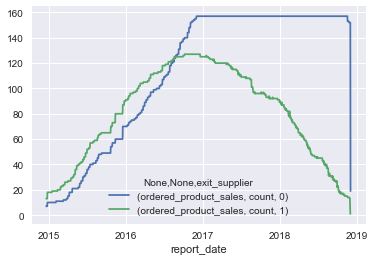

In [18]:
df[['report_date', 'exit_supplier', 'ordered_product_sales']].groupby(
    ['report_date', 'exit_supplier']).agg(['count']).unstack().plot();

The number of exit Suppliers drops gradually as we get closer to the analysis cut-off date, which is understandable and expected.

The unusual trend for non-exit Suppliers - levelling off at ca. 153 non-exit Suppliers per day - is most likely a result of data truncation to limit the dataset size. There is also a peculiar cut-off at the end, probably due to incompleteness of data:

In [19]:
df[['report_date', 'exit_supplier', 'ordered_product_sales']].groupby(
    ['report_date', 'exit_supplier']).agg(['sum', 'count']).unstack().tail(10)

ordered_product_sales                      
                                sum           count      
exit_supplier                     0        1      0     1
report_date                                              
2018-11-22               180,869.34 2,424.50 153.00 14.00
2018-11-23               412,839.70 2,382.22 153.00 14.00
2018-11-24               218,216.77 1,131.35 152.00 14.00
2018-11-25               257,736.00 1,801.23 152.00 14.00
2018-11-26               781,630.43 2,816.39 152.00 14.00
2018-11-27               327,516.03    87.86 152.00 13.00
2018-11-28               314,767.41     0.00 152.00 13.00
2018-11-29               274,607.13     0.00 152.00  7.00
2018-11-30               282,279.53     0.00 152.00  1.00
2018-12-01               145,906.80      nan  19.00   nan

Also something to keep in mind for further analysis. Interestingly, on December 1st only 19 Suppliers generated over 50% of previous day sales!

### Sales Trend Analysis

In order to better understand the sales trends and their effect on the Suppliers decision to stop using Payability, we will aggregate the data to monthly level. The reasons for this are the following:
1. Reduction of daily data noise impact on the signal
1. Increased ease of calculation
1. Apart from the weekly cyclicality (which can be accounted for e.g. by adding number of weeks in a month in the dataset) lack of evidence for strong intra-month drivers of sales trend
1. On average a Supplier uses the Payability service for 35 (non-exit) or 30 (exit) months - see below - giving sufficient data to observe trend inclines or declines

In [20]:
print('Number of months of Supplier activity (exit / non-exit)\n',"="*50)
round(df[['supplier_key', 'exit_supplier', 'report_date']].groupby(
    ['supplier_key', 'exit_supplier']).count().unstack().agg(['mean', 'std', 'min', 'max']) / 30)

Number of months of Supplier activity (exit / non-exit)


report_date      
               0     1
mean       35.00 30.00
std         7.00  6.00
min        24.00 24.00
max        48.00 48.00

In order to aggregate the data to monthly level, we will extract the year and month combination from the `report_date` and `churn_date` features:

In [21]:
for col in ['report_date', 'churn_date']: df[col+"_yrmth"] = df[col].apply(lambda x: datetime.datetime(x.year, x.month, 1) if pd.notnull(x) else np.nan)

Let's see the monthly aggregated sales plot:

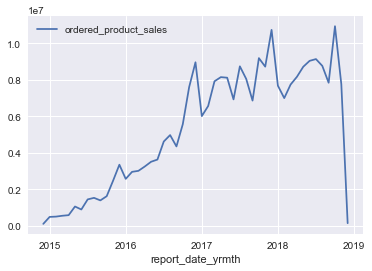

In [22]:
df[['report_date_yrmth', 'ordered_product_sales']].groupby(
    ['report_date_yrmth']).sum().plot();

The signal appears to be much clearer which is what we've been after. The drop at the end is as we've already seen a result of incomplete data for December 2018. Therefore we'll truncate the December data from our dataset:

In [23]:
df = df[df['report_date'] < datetime.datetime(2018, 12, 1)]

Now before we get to the next transformations, we need to look back at the hypotheses formulated by the Customer Service. We want to understand the impact sales trend inclines and declines have on the decision to leave Payability. 

To do this we first need to define what a sales incline of decline is in the context of our data. There are multiple ways one can go about this. We could fit a function (e.g. a GAM model like the one used earlier or even a linear regression on the sales growth rates) to obtain the trend signal and use it to analyse the historical movements.

Since we want to analyse such movements at a granular (Supplier) level, it would be reasonable to use a simpler approach to go easy on the calculations. **We can therefore define sales incline / decline as a positive / negative difference between short- and long-term moving averages**. In other words, if the short-term average sales exceed / fall short of the long-term average, it should mean a consistent trend increase / decrease. The use of two moving averages will further reduce impact of noise / outliers and produce a more robust signal.

Given the annual cycle of sales data that we observed earlier, a good choice for the short- and long-term averages would be 3 and 12 months respectively:

In [24]:
st = 3
lt = 12

On top of the moving averages and the difference between them we will calculate the number of months of consecutive trend increase and decrease separatly. We will calculate these MA related stats for all numeric features in our dataset just in case:

In [25]:
# helper function to increment counter if the trend is inclining / declining  for consecutive months
def trend(x, incl=False):
    global i
    if incl: x *= -1
    if x < 0:
        i += 1
    else:
        i = 0
    return i


# helper function to calculate moving average stats for the numeric features of the dataset
def rolling_stats(col, n_col, st, lt):
    cust[f'{n_col}_{lt}M'] = cust[col].rolling(window=lt, min_periods=1).mean()
    cust[f'{n_col}_{st}M'] = cust[col].rolling(window=st, min_periods=1).mean()
    cust[f'{n_col}_st-lt'] = cust[f'{n_col}_{st}M'] - cust[f'{n_col}_{lt}M']
    i = 0
    cust[f'{n_col}_decl_m'] = cust[f'{n_col}_st-lt'].apply(lambda x: trend(x))
    i = 0
    cust[f'{n_col}_incl_m'] = cust[f'{n_col}_st-lt'].apply(lambda x: trend(x, incl=True))

Ok, it's time to perform the calculation. The result will form a part of a new dataframe where we will add stats related to the churn event:

In [26]:
%%time
cols = [('ordered_product_sales', 'sales'),
        ('ordered_product_sales_b2b', 'sales_b2b'),
        ('units_ordered', 'units'),
        ('units_ordered_b2b', 'units_b2b'),
        ('units_refunded', 'refun')]

edf = pd.DataFrame()
keys = df['supplier_key'].unique()

for key in keys:
    cust = df[df['supplier_key'] == key].groupby('report_date_yrmth').sum()[list(map(lambda x: x[0], cols))]
    for col, n_col in cols:
        rolling_stats(col, n_col, st=st, lt=lt)
    cust['supplier_key'] = key
    if len(edf) > 0:
        edf = pd.concat((edf, cust))
    else:
        edf = cust

edf = edf.reset_index()

## CHURN STATS:
edf = edf.merge(churn, how="left", on="supplier_key")
edf['churn_date'] = pd.to_datetime(edf['churn_date'])
edf['exit_supplier'] = edf['churn_date'].apply(func=(lambda x: 1 if pd.notnull(x) else 0))
edf['churn_event'] = (edf['churn_date'].map(str).apply(lambda x: x[:7]) == edf['report_date_yrmth'].map(str).apply(lambda x: x[:7])).astype('int32')

Wall time: 2min 13s


Time to verify the calculations. First, let's check if the aggregate trend still looks the same on the new dataset:

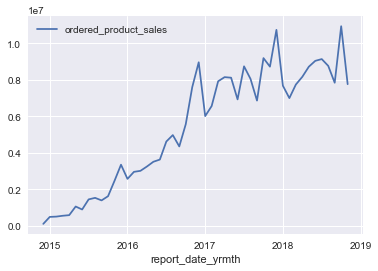

In [27]:
edf[['report_date_yrmth', 'ordered_product_sales']].groupby('report_date_yrmth').sum().plot();

Now, let's visualise the results for a random sample of exit and non-exit Suppliers:

In [28]:
def plot_suppliers(smpl, exit=True):
    e = 1 if exit else 0
    suppliers = np.random.choice(edf['supplier_key'][edf['exit_supplier'] == e].unique(), size=smpl, replace=False)

    for i, supplier in enumerate(suppliers):
        churn_date = str(edf['churn_date'][edf['supplier_key'] == supplier].unique()[0])[:10]
        print(
    f"""
{i + 1}) {supplier}
{40*'='}
Churn date: {churn_date}
    """)
        edf[['report_date_yrmth', 'ordered_product_sales', f'sales_{lt}M',
               f'sales_{st}M']][edf['supplier_key'] == supplier].groupby('report_date_yrmth').sum().plot()
        plt.show()


1) 18755f48-b8e3-4458-a2f2-166691d30dab
Churn date: 2017-09-05
    


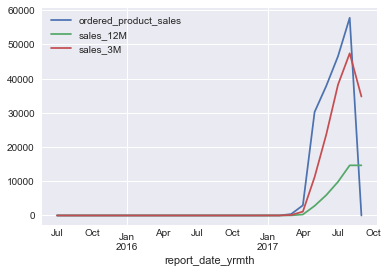


2) a325f9ee-82c1-459a-89b6-25234df5f591
Churn date: 2018-07-26
    


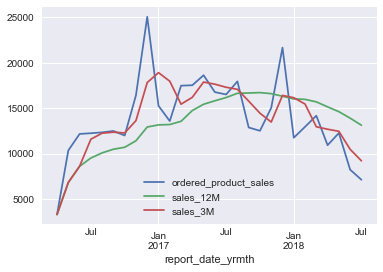


3) 2606d53c-8d29-4a63-851e-1b622ba24070
Churn date: 2018-11-09
    


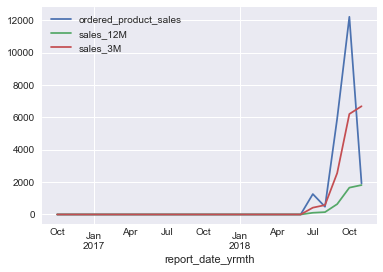


4) 4a31ebe0-f077-4a94-b3a9-7ea7b72a71f4
Churn date: 2017-11-18
    


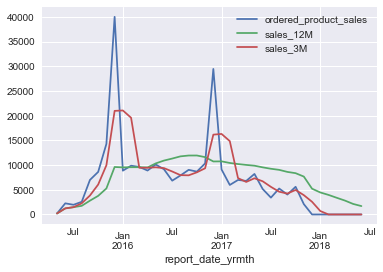


5) 0574ad4e-5331-4e0b-9dd5-70d8fd3ba01b
Churn date: 2018-01-19
    


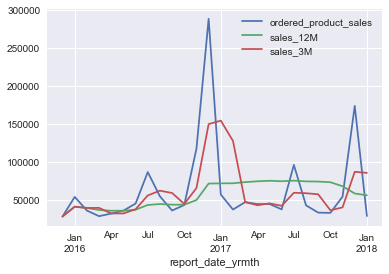


6) 8c8f0374-7a45-4287-b461-d4346d62a4ae
Churn date: 2018-10-03
    


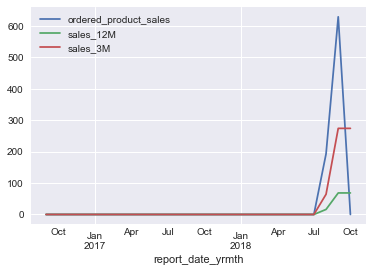


7) cf109b42-19c2-433a-8b2d-9f666e49f78b
Churn date: 2018-09-07
    


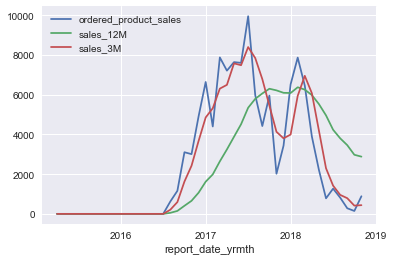


8) e2b80206-619f-4aae-8e3f-80c6555e8055
Churn date: 2018-04-19
    


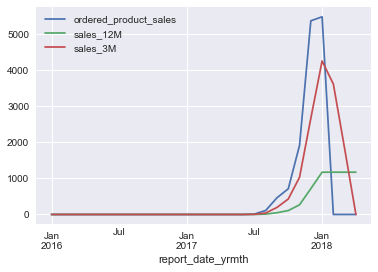


9) 8e92ba5f-0690-4106-bb6b-0ea7145edb4d
Churn date: 2018-10-06
    


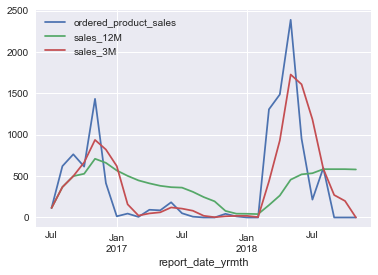


10) a2493a24-da7a-47d1-97e8-363bb22b2aee
Churn date: 2018-01-16
    


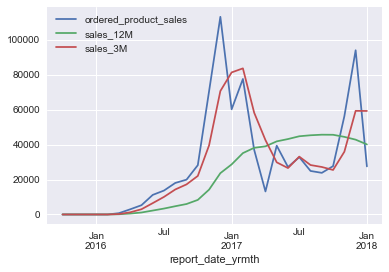


11) dfb41fd4-dca2-429e-92fd-533c36461127
Churn date: 2018-11-16
    


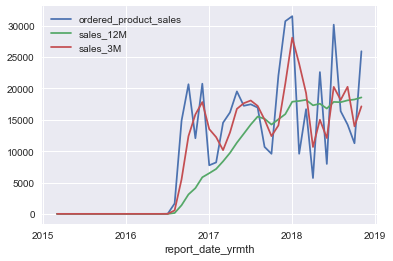


12) bb0dc14b-5f60-4928-8ddf-d12415225a4e
Churn date: 2018-05-11
    


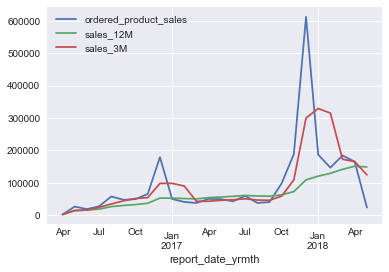


13) 30173af5-7936-4692-8da3-31fa7c89251e
Churn date: 2018-02-15
    


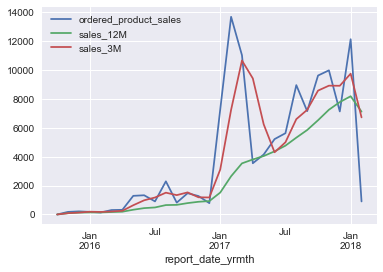


14) 7e3a391a-299c-4e60-ae1e-eef97b9d89a3
Churn date: 2017-02-17
    


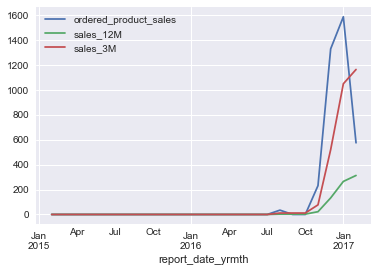


15) e051e19c-38d0-4e43-8747-b97309a4eae8
Churn date: 2018-10-10
    


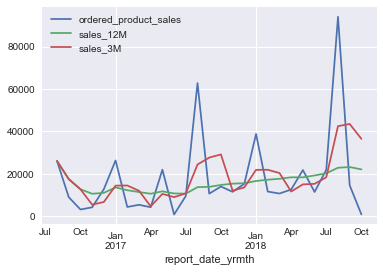


16) 807c356f-84a5-4272-b390-fc614b4fcde3
Churn date: 2017-12-30
    


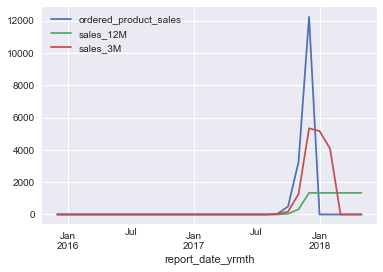


17) 9730c910-056d-49be-9e8f-bde264c7b29d
Churn date: 2018-01-31
    


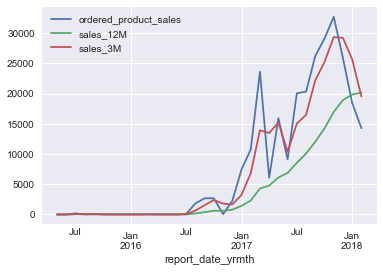


18) 4467bab8-4c20-4765-9e72-83aa43d34724
Churn date: 2018-01-26
    


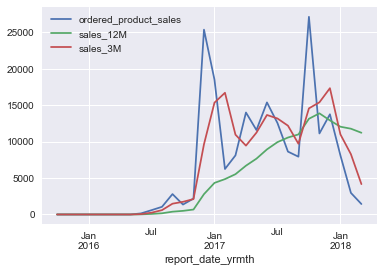


19) 321d20e3-8fc0-4312-bb29-ef8e9af6a65b
Churn date: 2018-02-18
    


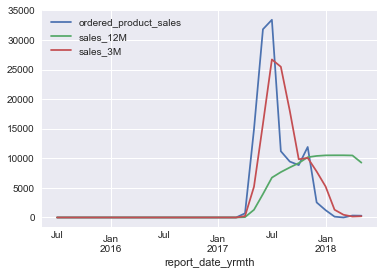


20) b2a48c75-bb64-4194-9b15-d1b61c6aae51
Churn date: 2017-12-03
    


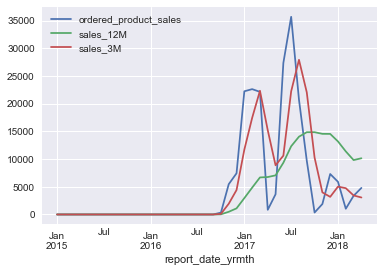


21) 7685b626-a1b4-48cc-ad3a-65c6412ca7e1
Churn date: 2017-03-31
    


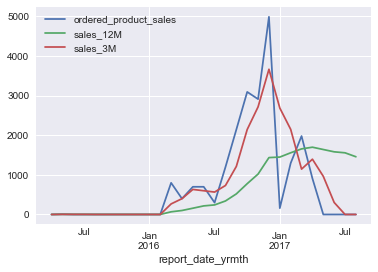


22) 5a900563-f136-4d93-8177-aa03423d39f1
Churn date: 2018-04-17
    


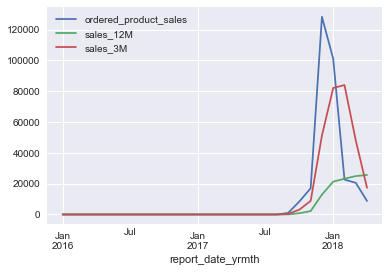


23) 2a833091-a3f1-4bf6-ad56-8405c2da81dc
Churn date: 2018-07-24
    


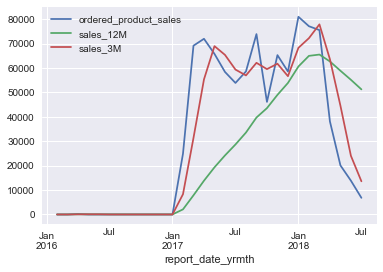


24) d5ae9100-fce3-4f3a-9774-1b633f54464c
Churn date: 2018-02-15
    


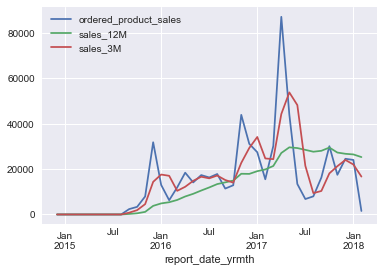


25) b054d7e5-8f51-4920-bcff-982e5d6bd7f1
Churn date: 2017-09-29
    


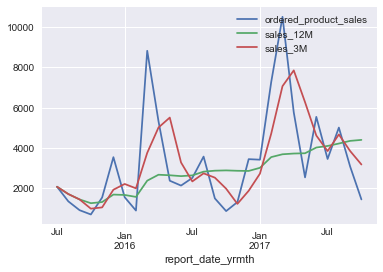

In [29]:
plot_suppliers(25, exit=True)


1) 87e5fe51-0c0f-4f0f-8149-f4b742dc5fc4
Churn date: NaT
    


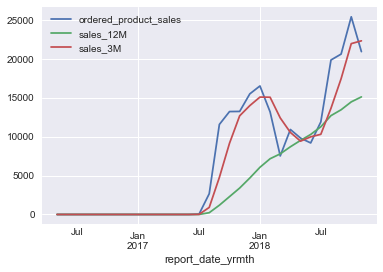


2) 0bef67aa-7309-434f-9724-1f8d544af6b0
Churn date: NaT
    


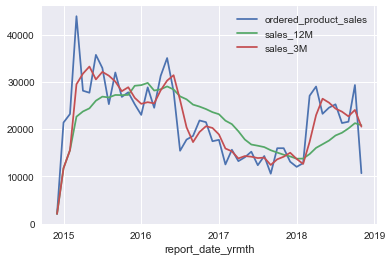


3) a3c7f584-6f3b-48fd-9743-ed4a96ade1e0
Churn date: NaT
    


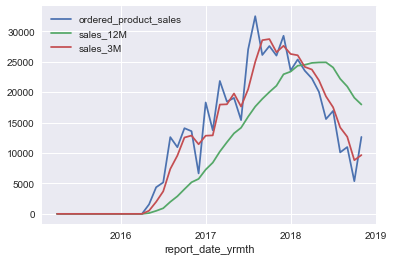


4) 88dddbed-e792-4821-a5e4-7abcae75ec54
Churn date: NaT
    


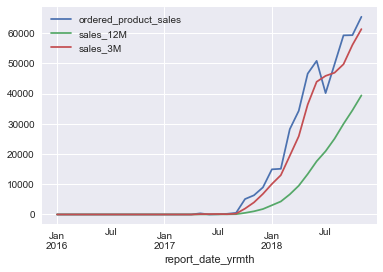


5) 4f4f83ad-9338-4db9-8e6e-0e35d7ddd3b1
Churn date: NaT
    


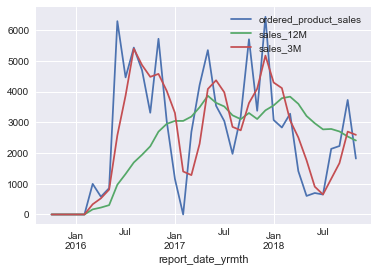


6) 83794c98-5964-46d2-87b2-70fe41da91fc
Churn date: NaT
    


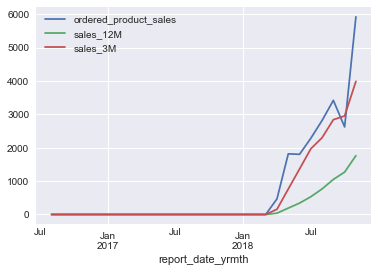


7) 642b64fe-39ca-4bbd-901b-63d2f9022bfa
Churn date: NaT
    


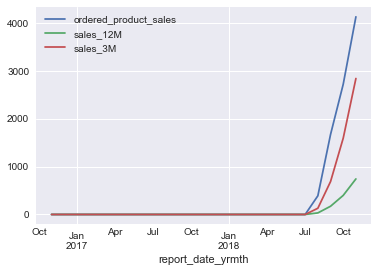


8) f40b38f2-bae2-4aa8-903a-1c164aaf367d
Churn date: NaT
    


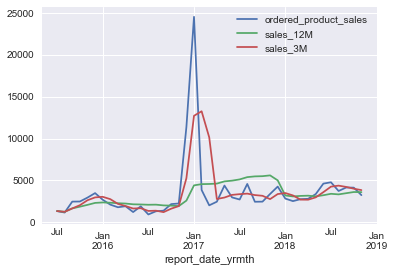


9) eb0f1682-c6a5-47dc-b519-fa10dc470f50
Churn date: NaT
    


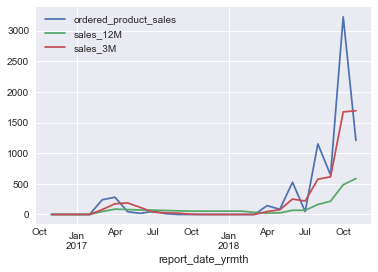


10) aa21005c-8b57-4885-ae0f-45fc3fce502c
Churn date: NaT
    


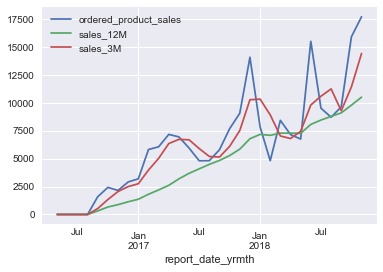


11) 66a025aa-0d74-4a50-b2d1-69fd2f85a28c
Churn date: NaT
    


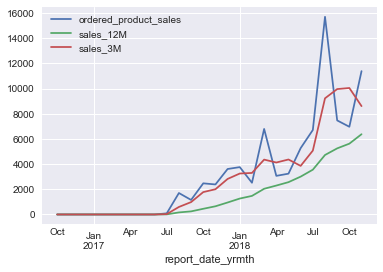


12) 924932a6-8766-42bb-81cb-4efe81ce8054
Churn date: NaT
    


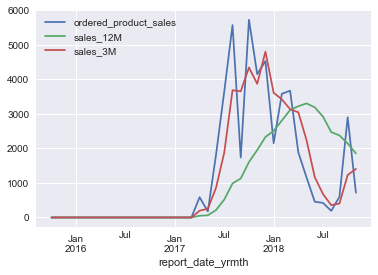


13) 8ac5ff13-c15e-40e5-adac-0ca0f83bab80
Churn date: NaT
    


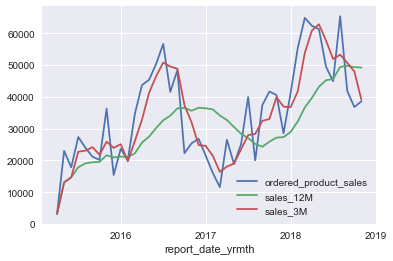


14) d9d5a89a-bf60-4e7e-ac17-9fb7d9df0ad1
Churn date: NaT
    


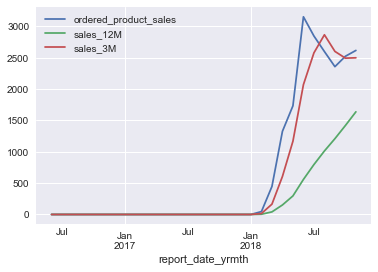


15) 65c6d42a-d6f9-49d2-b5ef-cfb88314fbc6
Churn date: NaT
    


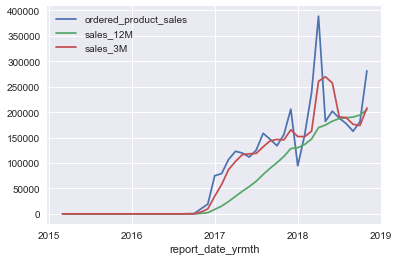


16) 648f0ae8-7dd5-410e-bdd0-ae0331bc67c7
Churn date: NaT
    


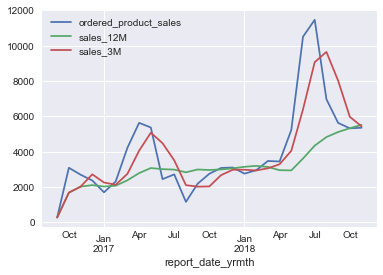


17) 41fdf918-bf27-4a86-bed7-b082f0508e8d
Churn date: NaT
    


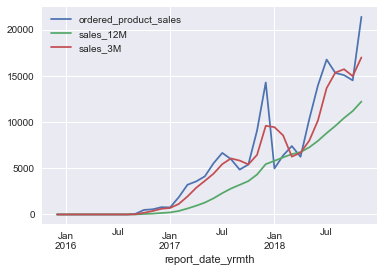


18) 62ee9dd3-1242-4b39-9f44-1c760c088d04
Churn date: NaT
    


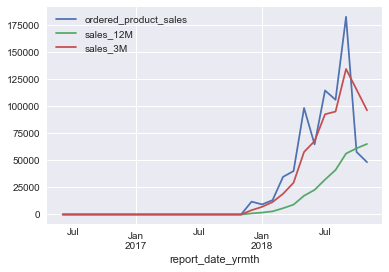


19) 1dac2899-00d8-4dca-b6c7-f6cc56a461b8
Churn date: NaT
    


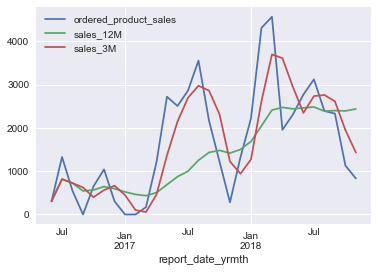


20) bb87133f-3d5d-4b87-a6b0-8e42f22da7f3
Churn date: NaT
    


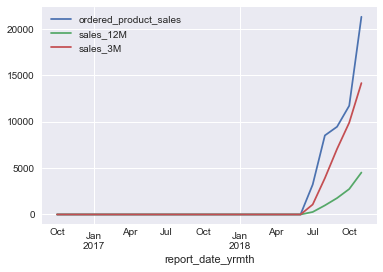


21) 49ed2abb-d324-4b09-ab55-c0245323f81b
Churn date: NaT
    


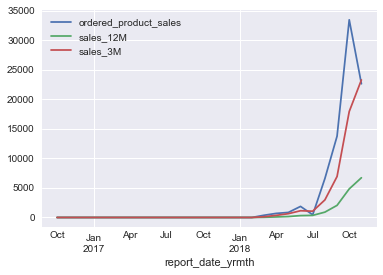


22) c559ef80-3e66-4a51-9d62-4d353aa255c9
Churn date: NaT
    


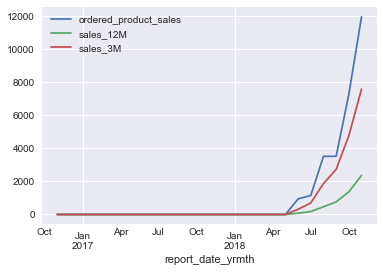


23) 20231b2d-5708-4df3-9349-8a47ca934f55
Churn date: NaT
    


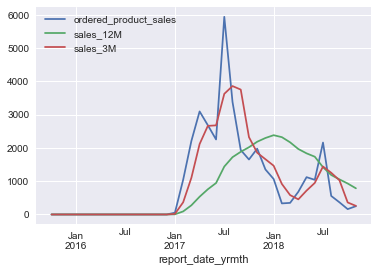


24) f440491c-003f-47f1-a26f-ef31823d5002
Churn date: NaT
    


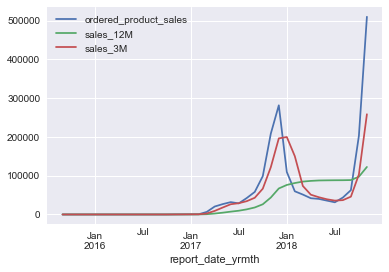


25) b08f3ab5-245c-4d9d-8cf4-2e7404a862b5
Churn date: NaT
    


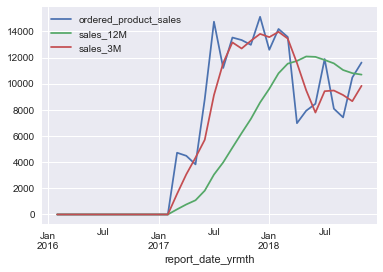

In [30]:
plot_suppliers(25, exit=False)

Visual inspection of the above plots shows the MA's are doing a reasonable job of describing the overall trend.

On the exit Supplier plots we can also see some examples similar to what Customer Services have reported: some clients exiting after a period of sales decline and some after a period of fast increase. However it is worth noting that some of the non-exit Suppliers also display similar rapid growth / drastic decline tendencies so visual inspection is not enough to determine if Customer Services are right.

We can now check what ratio of Suppliers that left in the last 12 months displayed sales declines or inclines for over a quarter of a year before the churn date:

In [31]:
m = 3

cev = edf[['supplier_key', 'ordered_product_sales', 'sales_3M', 'sales_decl_m', 'sales_incl_m']][
    (edf['churn_event'] == 1) & (edf['report_date_yrmth'] > '2017-11-01')].groupby('supplier_key').sum().reset_index()

den = cev.shape[0]
print("Last 12 months Supplier exits")
print("="*10)
print(f"-> Sale Declines (over {m} months): {cev[cev['sales_decl_m'] > m].shape[0] / den * 100:.2f}%")
print(f"-> Sale Inclines (over {m} months): {cev[cev['sales_incl_m'] > m].shape[0] / den * 100:.2f}%")

Last 12 months Supplier exits
-> Sale Declines (over 3 months): 25.88%
-> Sale Inclines (over 3 months): 36.47%


The numbers are within the ballpark figure given by Customer Service.

Time to check the correlation table, limiting the data to the last year of the analysis. Before we do, we will define some additional features: `no_sales` (indicating where sales have gone below 10% of the long-term average), `sales_growth` (ratio of the difference between short- and long-term MA'a to the long-term MA) and `sales_abs_trend` (combination of the incremental sales incline and decline features): 

In [32]:
edf['no_sales'] = (edf['ordered_product_sales'] < 0.1*edf[f'sales_{lt}M']).astype('int32')
edf['sales_growth'] = (edf['sales_st-lt'] / edf[f'sales_{lt}M']).clip(-1, 3)
edf['sales_abs_trend'] = edf['sales_incl_m'] + edf['sales_decl_m']

First, let's see how these features correlate to `exit_supplier`:

In [33]:
feats = ['sales_abs_trend', 'sales_incl_m', 'sales_decl_m', 'no_sales', 'sales_growth']
edf[['exit_supplier'] + feats][edf['report_date_yrmth'] > '2017-11-01'].corr()['exit_supplier']

exit_supplier      1.00
sales_abs_trend   -0.03
sales_incl_m      -0.10
sales_decl_m       0.12
no_sales           0.39
sales_growth      -0.09
Name: exit_supplier, dtype: float64

No really strong correlations are apparent - the `no_sales` feature seems to be working best out of the ones selected, with an intuitive correlation sign.

Let's see the correlation table for `churn_event`:

In [34]:
edf[['churn_event'] + feats][(edf['report_date_yrmth'] > '2017-11-01')].corr()['churn_event']

churn_event        1.00
sales_abs_trend   -0.01
sales_incl_m      -0.03
sales_decl_m       0.04
no_sales           0.16
sales_growth      -0.03
Name: churn_event, dtype: float64

We observe very weak correlations, most likely due to sparsity of the data. `no_sales` still seems to be the strongest.

## Modelling

As mentioned above, the correlations with the extracted features seem to be weak. This might be a question of feature definition and would require further investigation.

Nevertheless, we will attempt to build a classifier model that given the numeric features in the `edf` dataframe will determine whether a churn event is likely or not.

Before we select features for modelling, let's add one more to the spectrum - `month` - that should help the model capture and correct for annual seasonality:

In [35]:
edf['month'] = edf['report_date_yrmth'].dt.month

Now, let's define the features that will be taken into account in the modelling phase:

In [36]:
feats = ['report_date_yrmth', 'ordered_product_sales',
       'ordered_product_sales_b2b', 'units_ordered', 'units_ordered_b2b',
       'units_refunded', 'sales_12M', 'sales_3M', 'sales_st-lt',
       'sales_decl_m', 'sales_incl_m', 'sales_b2b_12M', 'sales_b2b_3M',
       'sales_b2b_st-lt', 'sales_b2b_decl_m', 'sales_b2b_incl_m', 'units_12M',
       'units_3M', 'units_st-lt', 'units_decl_m', 'units_incl_m',
       'units_b2b_12M', 'units_b2b_3M', 'units_b2b_st-lt', 'units_b2b_decl_m',
       'units_b2b_incl_m', 'refun_12M', 'refun_3M', 'refun_st-lt',
       'refun_decl_m', 'refun_incl_m', 'sales_growth',  'sales_abs_trend',
       'no_sales', 'month', 'churn_event']

We will exclude the first year from the analysis to not distort the training, given our long-term MA has been set to 12 months:

In [37]:
to_model = edf[feats][edf['report_date_yrmth'] > '2015-12-01'].fillna(0).sort_values('report_date_yrmth').copy()

We will use the final 12 months as our validation set:

In [38]:
val = to_model['report_date_yrmth'] > '2017-12-01'
t_set = to_model[~val]
v_set = to_model[val]

Now, given that our `churn_event` is observed only for less than 1% of all observations:

In [39]:
t_set[t_set['churn_event'] == 1].shape[0] / len(t_set)

0.008006672226855712

..we need to address the issue of an imbalanced dataset, otherwise our model will be skewed towards the majority class (i.e. no churn event). 

There are multiple ways this issue as well - for now we will take the approach of oversampling of the minority class (churn event) so that both classes are evenly represented in the dataset:

In [40]:
n = t_set[t_set['churn_event'] == 0].shape[0]
t_set = t_set.append([t_set[t_set['churn_event'] == 1].sample(n=n, replace=True)])
t_set['churn_event'].value_counts()

1    5995
0    5947
Name: churn_event, dtype: int64

Now we're ready to define the input and label datasets for training and validation:

In [41]:
inp_t = t_set.drop(columns=['report_date_yrmth', 'churn_event']).astype('float32')
inp_v = v_set.drop(columns=['report_date_yrmth', 'churn_event']).astype('float32')
lab_t = t_set['churn_event']
lab_v = v_set['churn_event']

for t in [to_model, inp_t, inp_v, lab_t, lab_v]: print(t.shape)

(8296, 36)
(11942, 34)
(2301, 34)
(11942,)
(2301,)


For modelling purposes we will use a Random Forest classifier and apart from the standard scores for training and validation, we will use the F1 score to check if the model indeed tackles class imbalance successfully:

In [42]:
def review(inp_t, inp_v, lab_t, lab_v):
    m.fit(inp_t, lab_t)
    preds = m.predict(inp_v)
    print("-"*30, f'''
Training score: {m.score(inp_t, lab_t)*100:.2f}%
Validation score: {m.score(inp_v, lab_v)*100:.2f}%
Out-of-Bag score: {m.oob_score_*100:.2f}%
Validation F1 score: {f1_score(lab_v, preds):.4f}
    ''')

In [43]:
%%time
m = RandomForestClassifier(n_estimators=2000, max_features=0.65, min_samples_leaf=25,
                          n_jobs=-1, oob_score=True)

review(inp_t, inp_v, lab_t, lab_v)

------------------------------ 
Training score: 99.55%
Validation score: 94.65%
Out-of-Bag score: 99.42%
Validation F1 score: 0.1633
    
Wall time: 35.5 s


As feared, while the accuracy scores appear to indicate a very good model, the low validation F1 score (which combines precision and recall) actually hints that the model is handling the imbalance poorly.

This can also be observed in the confusion matrix:

In [44]:
def conf_mat(targ, preds):
    cm = confusion_matrix(targ, preds)
    d = pd.DataFrame(cm)
    d.index.name = 'Actuals'
    d.index.name = 'Predictions'
    
    plt.figure(figsize=(5, 5))
    plt.title("CONFUSION MATRIX")
    sns.heatmap(d, annot=True, cmap="seismic", fmt='.0f')

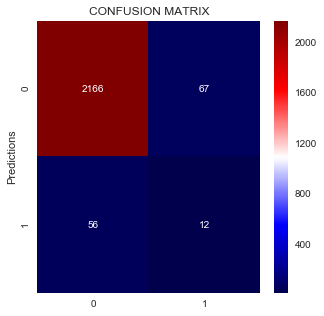

In [45]:
conf_mat(m.predict(inp_v), lab_v)

While the actual negatives are generally correctly classified, the majority of actual positives are misclassified as negatives (false negatives) and there's a relatively high number of false positives.

Finally, we will review the Receiver Operating Characteristic Area Under the Curve score, which measures the model performance under all possible classification thresholds:

In [46]:
print(f'Model ROC AUC score: {roc_auc_score(lab_v, m.predict_proba(inp_v)[:, 1]):.4f}')

Model ROC AUC score: 0.6920


Not surprisingly, the model performs rather poorly - it's closer to the benchmark score of 0.5 (i.e. random guessing) than to the maximum score of 1.

Nevertheless, we will still review the importance of the features used for modelling using the model obtained. To measure it, we will randomly reshuffle consecutive feature columns and compare the resulting predicion with the original unshuffled dataset. The intuition here is that the higher the difference, the higher the importance of a given feature was in the original prediction:

In [47]:
def feat_importance(num_feats=10):
    global scores
    scores = []
    targ = m.score(inp_t, lab_t)
    
    for col in inp_t.columns:
        inp_x = inp_t.copy()
        inp_x[col] = inp_x[[col]].sample(frac=1).set_index(inp_x.index)[col]
        scores.append([col, targ - m.score(inp_x, lab_t)])
        
        scores = sorted(scores, key=lambda x: x[1], reverse=True)
        pos = np.arange(len(scores))
        scores_names = [x[0] for x in scores]
        scores_s = [x[1] for x in scores]
        
    plt.figure(figsize=(8, 6))
    plt.title('All Features')

    plt.plot(scores_s)
    plt.tight_layout()  

    plt.figure(figsize=(8, 6))
    plt.title(f'Top {num_feats} Features')
    plt.barh(pos[:num_feats], scores_s[:num_feats], align='center')
    plt.yticks(pos[:num_feats], scores_names[:num_feats])
    plt.gca().invert_yaxis()      
    

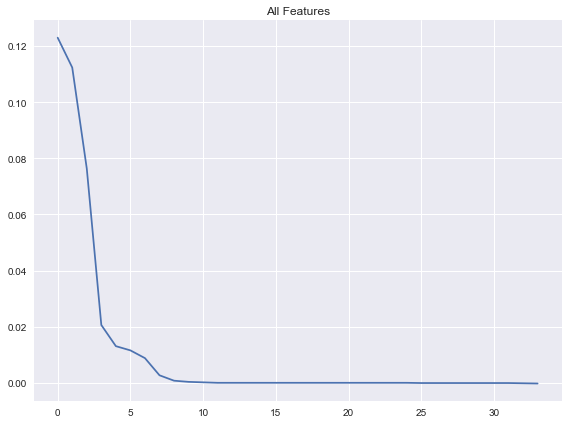

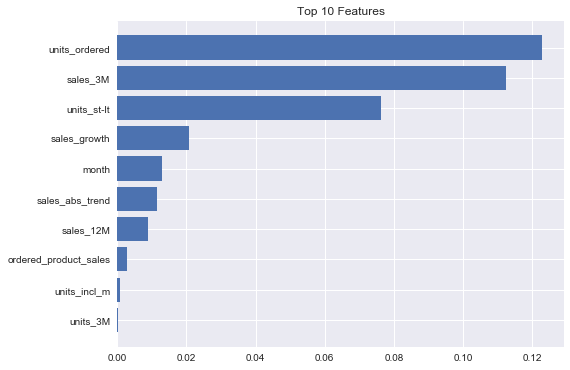

In [48]:
feat_importance()

According the the above model, the metrics based on units ordered appear to be among the strongest drivers - this hints on using units based drivers instead of sales based drivers in the analysis. Also, the `month` feature is a relatively important feature as expected from our EDA.

## Next steps

There is clearly room for improvement in the above analysis given the right amount of time and effort. To achieve this, the following steps could be tried out:
1. **Feature engineering**:
    1. Alternative definitions of trend movements
    1. Review of impact of units ordered rather than sales
    1. Alternative approach to defining the churn event - perhaps as a time window, rather than particular month
    1. Attempt at building metrics based on daily data
    1. If possible, collecting additional features outside of the current dataset
1. **Modelling**:
    1. Tryout of alternative architectures for classification, e.g. neural networks or gradient boosting trees
    1. Alternative approaches to addressing class imbalance (e.g. SMOTE)
    1. Further model interpretation steps (e.g. Tree Interpreter for CART related methods, partial dependance plots)
1. **Further use**:
    1. Once a decent churn event classifier is built, the next step could be to build regression models for the trend and use them in combination with the classifier to anticipate future churn